## Haystack <> [Langfuse](https://langfuse.com)

This integration utilizes the capabilites of langfuse in tracing down the execution of pipelines, API calls, prompts, and more. This traces down the input and output generated by every component of the pipeline so this helps in breaking down the where out performs so well or the vice versa. Then we can fine tune that specific component and improve the response.

### Installation

- First run the the command:

```bash
!pip install langfuse-haystack
```

- Then head to Langfuse dashboard: https://cloud.langfuse.com
- Sign up to a new account: https://cloud.langfuse.com/auth/sign-in
- Create a new project by providing any unique name

![langfuse-side-panel](https://gist.github.com/assets/81156510/aed54b08-11bf-47a4-9936-43758096a3c7)

- Then head to `Settings->API keys` and select `+ Create new API keys`.

![langfuse-api-key](https://gist.github.com/assets/81156510/c2e6e92c-cf18-44c5-8a50-49b7ad46bd56)

- Save those keys in a safe place as we would need them later.


### Import Libraries


In [30]:
import os
from getpass import getpass
import datetime

try:
    from haystack_integrations.components.connectors.langfuse import LangfuseConnector
except ModuleNotFoundError:
    !pip install langfuse-haystack
    from haystack_integrations.components.connectors.langfuse import LangfuseConnector

from haystack import Pipeline
from haystack.components.builders import DynamicChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

from langfuse import Langfuse

### Setup Environment variables

Note: Don't confuse with Langfuse Secret and Private key. Secret key starts with `sk-lf-...` and private key starts with `pk-lf-...`


In [2]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
os.environ["LANGFUSE_SECRET_KEY"] = getpass("Enter LANGFUSE_SECRET_KEY key:")
os.environ["LANGFUSE_PUBLIC_KEY"] = getpass("Enter LANGFUSE_PUBLIC_KEY key:")
os.environ["HAYSTACK_CONTENT_TRACING_ENABLED"] = "True"

### Create a Haystack Pipeline


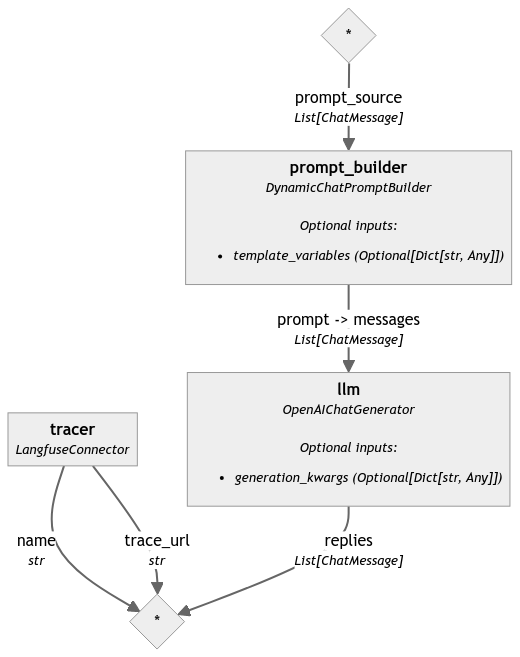

In [4]:
pipe = Pipeline()

# We can see here the Langfuse connector has been added as a component but not connected anywhere. The string parameter
# passed to the connector will be the name that will be reflected in the langfuse dashboard
pipe.add_component("tracer", LangfuseConnector("Chat example"))

pipe.add_component("prompt_builder", DynamicChatPromptBuilder())
pipe.add_component("llm", OpenAIChatGenerator(model="gpt-3.5-turbo"))

pipe.connect("prompt_builder.prompt", "llm.messages")
# pipe.draw("./langfuse-pipeline.png")

### Execute the pipeline

![langfuse-enabled-pipeline](https://gist.github.com/assets/81156510/fb870b15-eaff-4901-a234-b2fada3c6e67)

- We can see from the pipeline that there's a flat connection between `prompt_builder` and the `llm_generator`.
- The tracer is seperate the output from the generator i.e. `replies` are connected together which ensures the traces are captured.
- After execution we get the `ChatMessage(content="")` response.
- Also, we get a unique URL for every trace to debug the pipeline.
- Here's an example trace:
  ![langfuse-example-trace](https://gist.github.com/assets/81156510/1b3d7944-5df1-4e53-95f8-1a09a960389c)
- Debug the tracing:
- - We see the command that intiated the trace i.e. `haystack.pipeline.run`
- - Then we have the `prompt_builder` component with the input parameters sent. The `DynamicPromptBuilder()` sets the prompts dynamically.
- - The `ChatMessage` messages of every LLM conversation contains the context and is helpful in generation.
- - We pass the context using the `from_system` method of the associated dataclass.
- - Then the `tracer` component is invoked which contains the `name` and `trace_url`.
- - Finally, we log the generation of `llm` and we can see the input i.e. `ChatMessage` both `from_system` and `from_user` and the `response`.
- - We can view the time taken for each component to run as well as the metadata i.e. associated with every component.

Associated terminologies:

- [Span](https://langfuse.com/docs/sdk/python/low-level-sdk#span) : Span represent durations of units of work in a trace.
- [Generation](https://langfuse.com/docs/sdk/python/low-level-sdk#generation) : Generations are used to log generations of AI models.

We have a lot of data provided through Langfuse but let's see how we use these metrics which highlights the core feature of this connector.

- Easy integration with Haystack pipelines : With just 2 lines of code we have the Langfuse Tracer up and running. This is abstraction is really easy as a developer to focus on other aspects of the projects rather.

```python
from haystack_integrations.components.connectors.langfuse import LangfuseConnector
pipe.add_component("tracer", LangfuseConnector("Chat example"))
```

- Capture the full context of the execution : Whenever, we run a Haystack pipeline we have various components that come into picture. As a user we know only the inputs and outputs. But there are many components running in between. These componentes are being hidden though really necessary for organization to understand how the model performs. So we need to log the details of every component and track the inputs and outputs being generated to understand more about where the pipeline needs to be improved. In our pipeline we have 4 components namely: prompt_builder, tracer, llm. We can see what are the inputs, outputs and metadata associated with each of them via langfuse.

![prompt_builder](https://gist.github.com/assets/81156510/68d69f85-ab6b-4fd6-bfd7-0e41da60a9f7)

This shows all the necesssary details that were used to run the specific component. Where the `input` specifies the various parameters passed to the model. The `metadata` contains various other parameters that would be useful for tracing through langfuse. Last but not the least, the `output` that contains the response from the particular component that will be passed to the further components.

- Track model usage and cost : We can view how much did that particular generation cost. Also the name of the model used, tokens consumed, and latency.
  ![trace-cost-tracking](https://gist.github.com/assets/81156510/812480df-8779-43a9-97ff-725889335675)

- Collect user feedback : Now that we have the response there's comes the point how much is the user satisfied with the response base on the query. This is really useful to understand what more needs to be done to the pipeline to ensure the best results to the user. Langfuse has the [score](https://langfuse.com/docs/scores/overview) feature to assess the trace functionality. We can provide the score value and comments if applicable.
  ![trace-scoring](https://gist.github.com/assets/81156510/a42a8ac6-0350-40dc-8d18-5d2310a9a4d2)

- Identify low-quality outputs : This feature is most important to understand how, where and when the model fails. One way we can overcome this is through [user feedback / score](https://langfuse.com/docs/scores/overview#using-scores-across-langfuse). Those with less score are more likely to be assessed. If we consider a bigger picture we can [create a dataset](https://langfuse.com/docs/datasets/overview#creating-a-dataset) based on scores, span, generation and identify the pattern using ML, NLP techniques.

- Build fine-tuning and testing datasets : As discussed earlier, we can utilize the outputs and create dataset out of the same. [More context to be added]


In [5]:
messages = [
    ChatMessage.from_system(
        "Always respond in German even if some input data is in other languages."
    ),
    ChatMessage.from_user("Tell me about {{location}}"),
]

response = pipe.run(
    data={
        "prompt_builder": {
            "template_variables": {"location": "Berlin"},
            "prompt_source": messages,
        }
    }
)

trace_url = response["tracer"]["trace_url"]
print(response["llm"]["replies"][0])
print(trace_url)

ChatMessage(content='Berlin ist die Hauptstadt und zugleich die größte Stadt Deutschlands. Sie liegt im Nordosten des Landes und ist bekannt für ihre kulturelle Vielfalt, ihre lebendige Kunstszene und ihre bewegte Geschichte. Berlin ist berühmt für Sehenswürdigkeiten wie das Brandenburger Tor, den Berliner Dom, die Berliner Mauer und den Fernsehturm am Alexanderplatz. Die Stadt beherbergt viele Museen, Galerien, Theater und Konzertsäle, die von Besuchern aus aller Welt geschätzt werden. Zudem ist Berlin ein beliebtes Ziel für junge Menschen, da es viele Möglichkeiten zur Freizeitgestaltung gibt, von alternativen Clubs und Bars bis hin zu grünen Parks und Seen. In Berlin treffen traditionelle Architektur und moderne Hochhäuser aufeinander, was der Stadt eine einzigartige Atmosphäre verleiht.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 202, 'prompt_tokens': 29, 'total_tokens'

### Collecting user feedback [Scoring the Response]


In [28]:
# Create a langfuse client
langfuse = Langfuse()

In [7]:
# Get the trace id from trace_url
trace_id = trace_url.split("/")[-1]

# Get the inputs of the response to be scored
value = float(input("Enter the value of response satisfaction between (0-1): "))
comments = input("Give additional feedback on the response: ")

# Now add the score to the response
langfuse.score(trace_id=trace_id, name="quality", value=value, comment=comments)

### Creating a Dataset using the Traces


In [31]:
# Get the name of the dataset
dataset_name = input("Enter the name of the dataset: ")

# Author
author = input("Enter author name: ")

# Date
date = datetime.date.today()

In [33]:
# Let's create a dataset using the langfuse client
langfuse.create_dataset(
    name=dataset_name,
    description="haystack-langfuse-integration-dataset",
    # optional metadata
    metadata={"author": author, "date": date, "type": "benchmark"},
)

Dataset(id='clwdht5na0001qzrwch5oa7l9', name='haystack-example-pipeline', description='haystack-langfuse-integration-dataset', metadata={'date': '2024-05-19', 'type': 'benchmark', 'author': 'Sriniketh'}, project_id='clw6istwv0000h61z93rkiuds', created_at=datetime.datetime(2024, 5, 19, 12, 7, 34, 870000, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2024, 5, 19, 12, 7, 34, 870000, tzinfo=datetime.timezone.utc), items=[], runs=[])